In [1]:
pip install praw --upgrade praw

Note: you may need to restart the kernel to use updated packages.


In [2]:
import praw
from praw.models import MoreComments
import string
import re
import nltk 
from nltk.text import Text
from nltk.draw.dispersion import dispersion_plot
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.collocations import BigramCollocationFinder


## Load raw data

In [3]:
def get_post_data():
    reddit = praw.Reddit(client_id='-sgTOKuB8OpYmcvV0gf1DQ', \
                         client_secret='p3cKCHZ4xhK0PVUzB9KUhupYpNvuHg', \
                         user_agent='crawler')
    url = "https://www.reddit.com/r/Coronavirus/comments/pbo8yv/misinformation_is_bad_good_information_is_good/"
    data = reddit.submission(url=url)

    return data

In [4]:
raw_posts = get_post_data()

## Inspect raw data

In [5]:
def inspect_raw_posts(raw_posts):
    for top_level_comment in raw_posts.comments:
        print(top_level_comment.body)

In [6]:
inspect_raw_posts(raw_posts)

The moderators of this sub support efforts to more strongly combat COVID-19 misinformation on Reddit. We believe our sub is one of the best places on Reddit, and maybe the internet, to get accurate and timely information on the pandemic, and we take a strong stance against misinformation. In our opinion, it would be counterproductive to make one of the most accurate subs on Reddit private in order to combat misinformation on Reddit. If you would like to discuss the current happenings in regards to subs going private, please do so on this sticky. Feel free to share this post with others who are seeking accurate information. All other meta-drama comments will be removed. Thanks!
When I read COVID misinformation that is completely contrary to the overwhelming consensus of the medical community, I’m reminded of all the weird shows that would come on late night cable TV when I was kid. 

Those cheaply produced shows, structured as a documentary, would convince people that there were actuall

AttributeError: 'MoreComments' object has no attribute 'body'

## Clean Text

In [7]:
def remove_links(post):
    post = re.sub("http\S*\s", "", post)
    return post

In [8]:
def lemmatize(post):
    lemmatizer = WordNetLemmatizer()
    lemmatized_post = lemmatizer.lemmatize(post) 
    return lemmatized_post

In [9]:
def remove_punctuation(post):
    table = str.maketrans('', '', string.punctuation) 
    post = [w.translate(table) for w in post] 
    return post

In [10]:
def remove_stopwords(post):
    stop_words = nltk.corpus.stopwords.words('english')
    new_stopwords = ["would" , "etc" , "url" , "https" , "jpeg"] 
    stop_words.extend(new_stopwords) 
    post = [w for w in post if not w in stop_words] 
    
    return post
  

In [11]:
def remove_digits(post):
    post = [w for w in post if w.isalpha()]
    return post

In [12]:
def clean_text(post):
   
    post = post.lower()
    post = remove_links(post)
    post = lemmatize(post)
    post = word_tokenize(post) 
    post = remove_punctuation(post)
    post = remove_stopwords(post)
    post = remove_digits(post)
  
    return post
    


## Apply text cleaning

In [13]:
def apply_text_cleaning(raw_posts):
    cleaned_posts = []
    for top_level_comment in raw_posts.comments[1:]:

        if isinstance(top_level_comment, MoreComments):
            continue #remove second level comments

        raw_post = top_level_comment.body
        cleaned_post = clean_text(raw_post)

        if cleaned_post in ["removed" , "deleted"]: #remove deleted comments
            continue

        cleaned_posts.append(cleaned_post)
        
    return cleaned_posts

In [14]:
cleaned_posts = apply_text_cleaning(raw_posts) 

## Check results of text cleaning

In [15]:
def inspect_cleaned_posts(cleaned_posts):
    for post in cleaned_posts:
        print(post ,"\n" )

In [16]:
inspect_cleaned_posts(cleaned_posts)

['read', 'covid', 'misinformation', 'completely', 'contrary', 'overwhelming', 'consensus', 'medical', 'community', 'reminded', 'weird', 'shows', 'come', 'late', 'night', 'cable', 'tv', 'kid', 'cheaply', 'produced', 'shows', 'structured', 'documentary', 'convince', 'people', 'actually', 'aliens', 'popping', 'ocean', 'daily', 'blurred', 'footage', 'ominous', 'talk', 'tracks', 'tell', 'monk', 'chinaindiawherever', 'could', 'stop', 'heart', 'restart', 'thinking', 'could', 'overcome', 'heatfreezing', 'cold', 'controlling', 'body', 'could', 'levitate', 'meditation', 'entertaining', 'watch', 'sure', 'without', 'even', 'bare', 'minimum', 'factchecking', 'stories', 'kid', 'could', 'even', 'mildly', 'convincing', 'felt', 'like', 'could', 'whole', 'reality', 'status', 'quo', 'completely', 'wrong', 'magic', 'might', 'real', 'happened', 'stumble', 'upon', 'tuesday', 'night', 'home', 'sick', 'school', 'even', 'kid', 'stake', 'life', 'truereal', 'light', 'firelock', 'freezerjump', 'building', 'absolu

## Prepare tokens for analysing

In [17]:
def transform_posts(cleaned_posts):
    transformed_posts = []
    for post in cleaned_posts:
        transformed_posts.extend(post)
    transformed_posts = Text(transformed_posts)
    return transformed_posts

In [18]:
transformed_posts = transform_posts(cleaned_posts) 

### Lexical dispertion

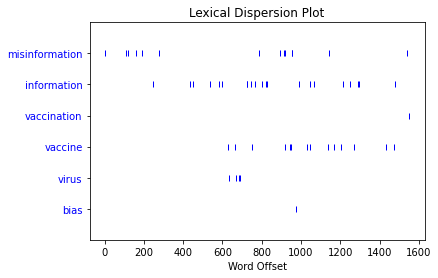

In [19]:
targets=["misinformation" , "information", "vaccination", "vaccine" , "virus" , "bias"]
dispersion_plot(transformed_posts, targets, title='Lexical Dispersion Plot')

### Frequency distribution

In [20]:

frequency_distribution = FreqDist(transformed_posts)
frequency_distribution.most_common(20)

[('information', 21),
 ('good', 16),
 ('people', 15),
 ('misinformation', 14),
 ('vaccine', 14),
 ('find', 12),
 ('covid', 11),
 ('data', 11),
 ('one', 11),
 ('source', 11),
 ('removed', 11),
 ('like', 10),
 ('twitter', 10),
 ('time', 10),
 ('get', 10),
 ('search', 9),
 ('google', 9),
 ('lot', 9),
 ('website', 8),
 ('use', 8)]

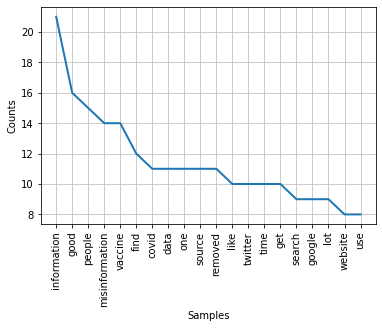

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [21]:
frequency_distribution.plot(20, cumulative=False)

### Collocations of "vaccine"

In [22]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
word_filter = lambda *w: 'vaccine' not in w
finder = BigramCollocationFinder.from_words(transformed_posts)
finder.apply_ngram_filter(word_filter)
finder.nbest(bigram_measures.likelihood_ratio , 10)

[('polio', 'vaccine'),
 ('figures', 'vaccine'),
 ('forefront', 'vaccine'),
 ('vaccine', 'card'),
 ('vaccine', 'causes'),
 ('vaccine', 'hesitancy'),
 ('vaccine', 'hesitant'),
 ('vaccine', 'mandates'),
 ('vaccine', 'okay'),
 ('vaccine', 'proving')]

In [23]:
transformed_posts.collocations(10)

side saying; fake news; executes clientside; screen shot; affect
fertility; financial incentive; points view; young women; costs money;
follow money
